In [1]:
import sys
sys.path.append("../")

from transformers import AutoTokenizer
from models.clip import CLIPTextTransformer, CLIPVisionTransformer, CLIPModel

In [2]:
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

2023-10-16 10:30:42.235172: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %fusion.5 = (u32[12648448]{0}, u32[12648448]{0}) fusion(), kind=kLoop, calls=%horizontally_fused_computation

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-10-16 10:30:42.358946: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.123851471s
Constant folding an instruction is taking > 1s:

  %fusion.5 = (u32[12648448]{0}, u32[12648448]{0}) fusion(), kind=kLoop, calls=%horizontally_fused_computation

This isn't necessarily a bug; constant-folding is inherently a trade-off betwee

In [3]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)
pstate = replicate(state)

In [82]:
logging_dir = '../logging/proposals/'
# run_name = 'autumn-darkness-67'
run_name = 'faithful-river-68'  # No crops

In [83]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state,)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [84]:
from models.dataset_utils import make_dataloader, create_input_iter

files = ['../data/tfrecords/observations_1.tfrecord','../data/tfrecords/observations_2.tfrecord','../data/tfrecords/observations_3.tfrecord','../data/tfrecords/observations_4.tfrecord', 
         '../data/tfrecords/observations_5.tfrecord','../data/tfrecords/observations_6.tfrecord','../data/tfrecords/observations_7.tfrecord','../data/tfrecords/observations_8.tfrecord',
         '../data/tfrecords/observations_9.tfrecord']

ds = make_dataloader(files, batch_size=32, seed=42, split='val')
batches = iter(ds)

## Zero-shot classification

In [95]:
import jax.numpy as np

images, captions = next(iter(ds))
images = np.array(images)
captions = captions.numpy().tolist()
captions = [c.decode('utf-8') for c in captions]

In [96]:
from dm_pix import center_crop

images = center_crop(images, 224, 224)
inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)

In [97]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")
claude_science_cat = ["star forming galaxies", "lyman alpha", "sfr", "dust", "crowded stellar field", "core-collapse supernova", "cosmology",  "gravitational lensing", "supernovae", "diffuse galaxies", "globular clusters", "stellar populations", "interstellar medium", "black holes", "dark matter", "galaxy clusters", "galaxy evolution", "galaxy formation", "quasars", "circumstellar disks", "exoplanets", "Kuiper Belt objects", "solar system objects", "cosmic web structure", "distant galaxies", "galaxy mergers", "galaxy interactions", "star formation", "stellar winds", "brown dwarfs", "neutron stars", "white dwarfs", "nebulae", "star clusters", "galaxy archeology", "galactic structure", "active galactic nuclei", "gamma-ray bursts", "stellar nurseries", "intergalactic medium", "galaxy clusters", "dark energy", "dwarf galaxies", "barred spiral galaxies", "irregular galaxies", "starburst galaxies", "dwarf galaxies", "low surface brightness galaxies", "ultra diffuse galaxies", "circumgalactic medium", "intracluster medium", "cosmic dust", "interstellar chemistry", "star formation histories", "initial mass function", "mass segregation", "stellar proper motions", "binary star systems", "open clusters", "pre-main sequence stars", "protostars", "protoplanetary disks", "jets and outflows", "interstellar shocks", "HII regions", "planetary nebulae", "supernova remnants", "stellar winds", "red giants", "Cepheid variables", "RR Lyrae variables", "stellar oscillations", "stellar abundances", "stellar rotation", "stellar magnetic fields", "stellar dynamics", "compact stellar remnants", "Einstein rings", "asteroids", "comets", "trans-Neptunian objects", "cosmic microwave background", "reionization epoch", "first stars", "first galaxies", "high-redshift quasars", "primordial black holes", "resolved binaries", "binary stars"]
claude_science_cat_inputs = tokenizer(claude_science_cat, padding="max_length", truncation=True, max_length=77, return_tensors="np")

def display_content(image, paragraph, classes):
    # Create a figure and define the grid specification
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

    # Display the image on the left subplot (spanning all rows)
    ax0 = plt.subplot(gs[:, 0])
    ax0.imshow(image)
    ax0.axis('off')  # Turn off axis numbers and ticks

    # Display the list of classes on the right subplot (spanning all rows)
    ax2 = plt.subplot(gs[:, 1])
    # Add ranking numbers and the title "Top Classes"
    ranked_classes = [f"{i+1}. {cls}" for i, cls in enumerate(classes)]
    class_text = "Top Classes:\n" + "\n".join(ranked_classes)
    ax2.text(0.5, 0.5, class_text, ha='center', va='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
    ax2.axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

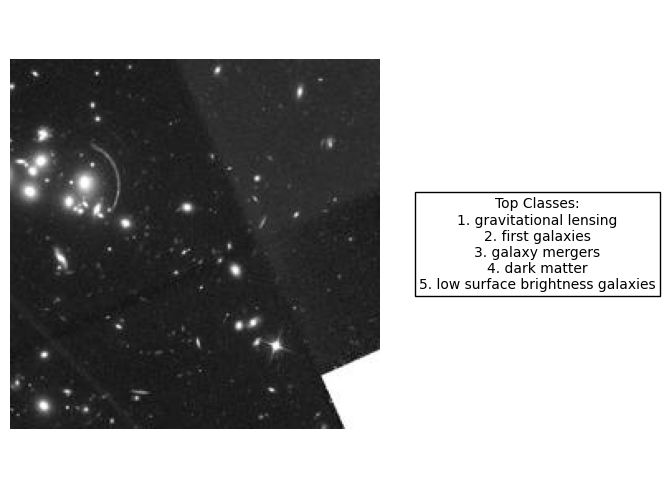

Category: GALAXIES & CLUSTERS CLUSTERS/LENSES. We propose deep multicolour WFC2 imaging of a sample of gravitationally-lensed `giant arcs' for which extensive ground-based data has already been secured. High resolution studies of these systems offer an unique probe of the dark matter distribution in the lensing clusters as well as of the nature of background field galaxies at redshifts above one. By resolving the arcs and their counter-images with HST, mass models that account for the lensing are much more highly constrained. This, in turn, will lead to an improved knowledge of the structure of the distant sources. Ground-based photometry indicates most arcs are intensely blue star-forming systems. Morphologies will provide important information on the ancestors of normal galaxies. Extrapolating the trends found in recent ground-based data, we also expect to identify many close image pairs in deep HST images. These pairs are probably highly magnified images of B=28-30 galaxies. The abu

In [98]:
idx = 0

image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
text_feat = model.get_text_features(**claude_science_cat_inputs, params=restored_state.params)

cats = [claude_science_cat[i] for i in np.argsort((text_feat @ image_feat.T)[:, 0])[::-1]][:5]

display_content(images[idx], captions[idx], cats)

print(captions[idx])

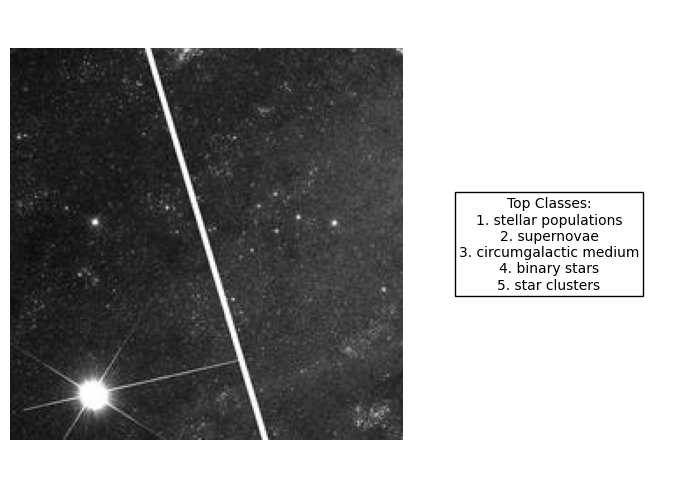

Category: Stellar Physics. During the past two decades, robotic (or highly automated) searches for supernovae (SNe), including our Lick Observatory Supernova Search (LOSS), have found over 1000 SNe, many of them in quite nearby galaxies (cz < 4000 km/s). Most of the objects were discovered before maximum brightness, and have follow-up photometry and spectroscopy; they include some of the best-studied SNe to date. We propose to continue our successful program of imaging the sites of some of these nearby objects, to obtain late-time photometry that will help reveal the origin of their lingering energy. We will also search for possible stellar remnants of Type Iax SNe, an intriguing new possibility. Moreover, the images will provide high-resolution information on the local environments of SNe that are far superior to what we can procure from the ground. For example, we will obtain color-magnitude diagrams of stars in these SN sites, to constrain the reddening and SN progenitor masses. We 

In [107]:
idx = 6

image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
text_feat = model.get_text_features(**claude_science_cat_inputs, params=restored_state.params)

cats = [claude_science_cat[i] for i in np.argsort((text_feat @ image_feat.T)[:, 0])[::-1]][:5]

display_content(images[idx], captions[idx], cats)

print(captions[idx])

## Image retrieval

In [108]:
from tqdm.notebook import tqdm

In [109]:
from models.dataset_utils import make_dataloader, create_input_iter

files = ['../data/tfrecords/observations_1.tfrecord','../data/tfrecords/observations_2.tfrecord','../data/tfrecords/observations_3.tfrecord','../data/tfrecords/observations_4.tfrecord', 
         '../data/tfrecords/observations_5.tfrecord','../data/tfrecords/observations_6.tfrecord','../data/tfrecords/observations_7.tfrecord','../data/tfrecords/observations_8.tfrecord',
         '../data/tfrecords/observations_9.tfrecord']

ds = make_dataloader(files, batch_size=32, seed=42, split='train')
batches = iter(ds)

In [110]:
import jax

image_feat_stack = []
images_stack = []
captions_stack = []

for _ in tqdm(range(200)):

    images, captions = next(iter(ds))
    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_stack += captions

    images_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=restored_state.params);
    image_feat_stack.append(image_feat)


  0%|          | 0/200 [00:00<?, ?it/s]

In [198]:
# ["andromeda m1", "dwarf galaxies and globular clusters", "gravitational lensing", "ISM"]

In [135]:
query = "globular cluster"
query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")

text_feat = model.get_text_features(**query_tokenized, params=restored_state.params)

In [136]:
sorted_idxs = np.argsort((np.vstack(image_feat_stack) @ text_feat.T)[:, 0])[::-1]

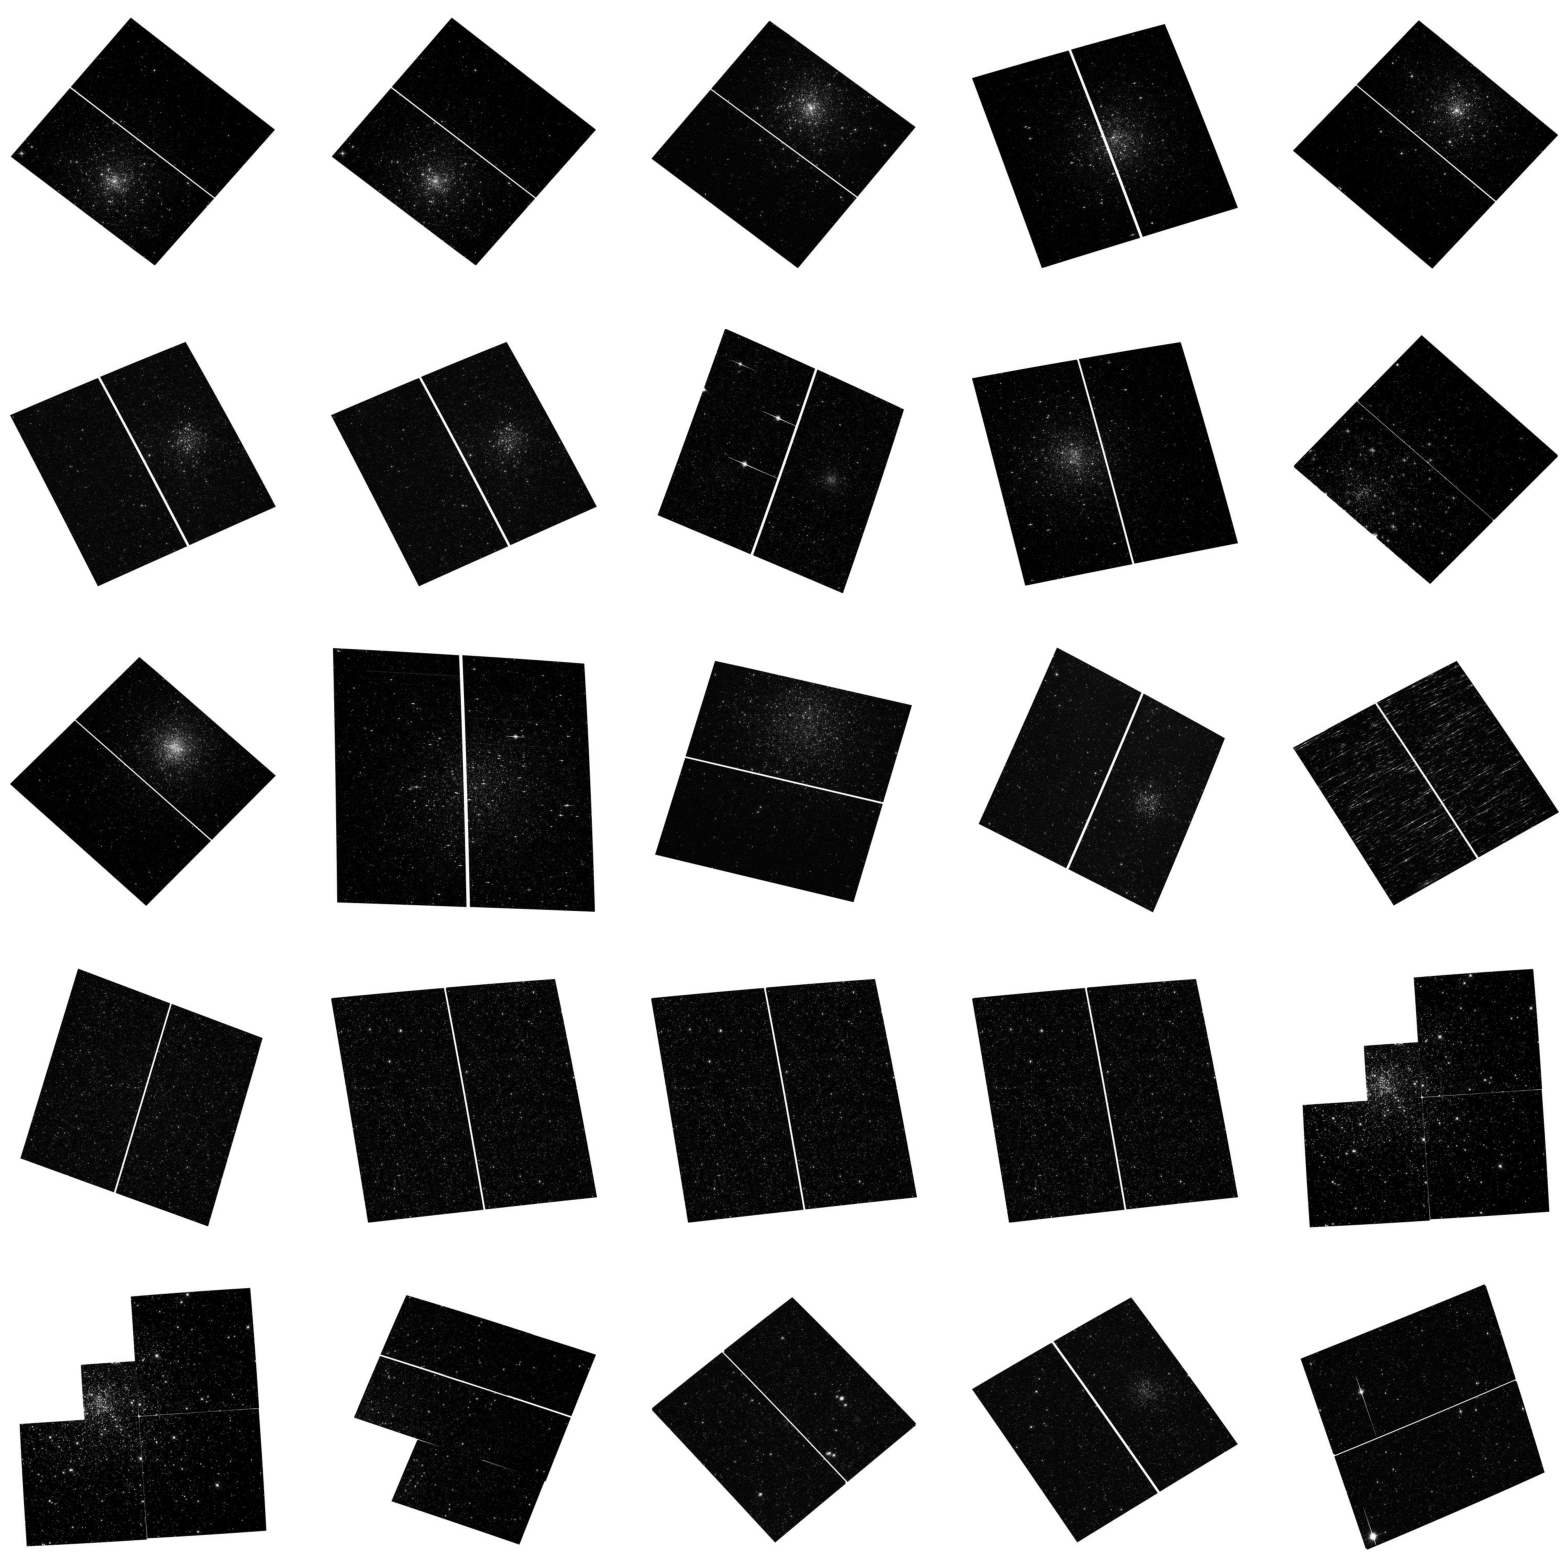

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

grid_size = 5

# Loop through the images in the batch and plot them in a grid
for i in range(grid_size * grid_size):
    
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(images_stack[sorted_idxs[i] // 32][sorted_idxs[i] % 32], vmin=0, vmax=1)
    plt.axis('off')  # Turn off axis numbers and ticks

plt.show()

In [138]:
[captions_stack[idx] for idx in sorted_idxs][:25]

['Category: HOT STARS. Globular Clusters {GCs} are old stellar systems tracing key stages of the star formation and chemical enrichment history of the early Universe and the galaxy assembly phase. As part of a project {COSMIC-LAB}  aimed at using GCs as natural laboratories to study the complex interplay between dynamics and stellar evolution,  here we present a proposal dealing with the role of Blue Straggler Stars {BSS}. BSS are core-hydrogen burning stars more massive than the main-sequence turnoff population. The canonical scenarios for BSS formation are either the mass transfer between binary companions, or stellar mergers induced by collisions. We have recently discovered two distinct and parallel sequences of BSS in the core of M30 {Ferraro et al. 2009, Nature 462, 1082}. We suggested that each of the two sequences is populated by BSS formed by one of the two processes, both triggered by the cluster core collapse, that, based on the observed BSS properties, must have occurred ~1